## **Phase 1 - Results**

This notebook initiates the results analysis phase of the BioPred_DS pipeline.  Our objective is to evaluate the performance of the optimized classification model on the held-out test set and quantify early enrichment metrics critical for compound screening and prioritization. 

The goals of this notebook are:

- Confirm PR AUC performance on the test set.
- Calculate early-stage enrichment metrics (EF@1%, EF@5%, EF@10%).
- Calculate precision metrics at selected k-values (Precision@10, Precision@50, Precision@100).
- SHAP analysis for feature importance.
- Visualize enrichment and precision trends across the ranked prediction list.
- Interpret results in the context of early-stage CNS drug discovery targeting GABA-A receptors.

## Importance of Enrichment Factor (EF) and Precision@k

In early-phase drug discovery, identifying true active compounds early in the screening process is critical for reducing costs, minimizing experimental effort, and accelerating time-to-clinic.

This notebook focuses on two key evaluation metrics for early-stage prioritization:

-----------------------------------

### **Enrichment Factor (EF@k%)**

The Enrichment Factor (EF) measures how much better the model is at identifying active compounds among the top-ranked predictions compared to random selection.

- **EF@1%**: Focuses on the top 1% of model predictions.
- **EF@5%**, **EF@10%**: Broader performance validation.

**Why EF Matters:**
- High EF indicates early recognition of actives.
- High EF reduces experimental screening burden.
- EF directly supports decision-making in hit-to-lead selection.

**Formula:**

$EF@k\% = \dfrac{TP_{\text{top-}k}}{\text{Total Actives} \times \left(\dfrac{k}{100}\right)}$

-----------------------------------

### **Precision@k**

Precision@k evaluates the fraction of true active compounds within the top *k* predictions.

- **Precision@10**: Precision within the top 10 compounds.
- **Precision@50**, **Precision@100**: Broader practical prioritization metrics.

**Why Precision@k matters**

- Measures how reliable the model's top suggestions are.
- Reflects expected success rates when selecting a small set of compounds for downstream assays.
- Supports resource allocation planning for experimental validation.

**Formula:**

$\text{Precision@k} = \dfrac{TP_{\text{top-}k}}{k}$

-------------------------------------

Together, EF@k% and Precision@k simulate real-workld resource-constrained experimental settings where only a fraction of predictions can be tested.  Strong early enrichment and high precision accelerate the discovery of potent candidates while reducing downstream development costs.

#### Load in artifacts to use in this notebook from previous and recalculate ROC AUC for validation before going forward.

In [1]:
import numpy as np
import pandas as pd
import joblib
import json
from pathlib import Path
from sklearn.metrics import average_precision_score, precision_recall_curve

# Load the model artifact
model_path = Path("../artifacts/models/xgboost_phase1.pkl")
model = joblib.load(model_path)

# Load test data arrays
X_test = np.load("../artifacts/arrays/X_test_phase1.npy")
y_test = np.load("../artifacts/arrays/y_test_phase1.npy")
y_proba = np.load("../artifacts/arrays/y_proba_phase1.npy")

# Check shape for good measure
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_proba shape: {y_proba.shape}")

# Confirm PR AUC score on our XGBoost model being used
pr_auc = average_precision_score(y_test, y_proba)
print(f"Test Set PR AUC: {pr_auc:.4f}")

# Load in our saved threshold for use later in notebook
threshold_path = Path("../artifacts/thresholds/phase1_thresholds.json")
with open(threshold_path, "r") as f:
    threshold_data = json.load(f)

# Retrieve the threshold amount from the stored json dict
threshold = threshold_data["precision_optimized_threshold"]

print(f"Loaded threshold: {threshold:.4f}")


X_test shape: (289, 2073)
y_test shape: (289,)
y_proba shape: (289,)
Test Set PR AUC: 0.9732
Loaded threshold: 0.6492


#### Define and Calculate the Enrichment Factor (EF@k%)

In [2]:
# Define a function to calc EF
def calc_ef(y_true, y_proba, percentage):
    """
    Calculates the Enrichment Factor (EF) at a given top percentage.

    Args:
        y_true - binary labels where (0 = inactive, 1 = active)
        y_proba - predicted probabilities from our model
        percentage - Top percentage to evaluate ("1" for 1%, etc)

    Returns:
        ef (float) -> EF at the given specificed percentage
    """
    n_total = len(y_true)
    n_top = int(n_total * (percentage / 100))

    # Sort predictings in descending order to get rank
    sorted_indices = np.argsort(y_proba)[::-1]
    top_indices = sorted_indices[:n_top]

    # Count true actives in top predictions
    true_positives_top = np.sum(y_true[top_indices] == 1)

    # Expected true positives under random selection
    true_positives_random = np.sum(y_true == 1) * (percentage / 100)

    # Enrichment Factor
    ef = true_positives_top / true_positives_random

    return ef

# Calculate EF at different top percentages using optimized probabilities
ef_1 = calc_ef(y_test, y_proba, 1)
ef_5 = calc_ef(y_test, y_proba, 5)
ef_10 = calc_ef(y_test, y_proba, 10)

# Display results
print(f"EF@1%: {ef_1:.2f}")
print(f"EF@5%: {ef_5:.2f}")
print(f"EF@10%: {ef_10:.2f}")


EF@1%: 0.98
EF@5%: 1.37
EF@10%: 1.37


### Enrichment Factor (EF) Summary

The Enrichment Factor (EF@k%) were calculated to evaluate how well the model enriches for active compounds within the top ranked predictions.  These values simulate a resource-constrained drug screening environment, where only a small fraction of the compound space can be experimentally tested.

### Results:
- **EF@1%** = 0.98
- **EF@5%** = 1.37
- **EF@10%** = 1.37

### Interpretation:

- **EF@1% ~ 1.0**: The model does not substantially outperform random selection in the top 1% of predictions.  While it globally ranks actives above inactives well (as confirmed by our PR AUC ~ 0.973), it does not sharply concentrate actives at the very top.
- **EF@5-10% > 1.0**: The model demonstrates modest early enrichment across broader selection thresholds, identifying ~37% more actives than expected under random screening.  This remains a **statistically meaningful gain** for early-phase hit detection.

### Project Implications:

While EF@1% enrichment is limited, the broader enrichment at 5-10% supports continuing the project into subsequent phases:

- **Phase 2**: Model interpretation and feature attribution remain meaningful for biological exploration.
- **Phases 3-4**: Pathway mapping and off-target effect predictions will not be hindered by early enrichment metrics, as they focus on compound ranking and biological clustering.
- **Phase 5**: Repurposing opportunities are still viable within the enriched top 5-10% space.

Given the nature of GABA-A receptor pharmacology and the relatively small and imbalanced dataset (~15 actives out of ~2800 compounds), these results are aligned with expectations for a real-world CNS target space.

---

### Limitations and Data-Driven Constraints

The EF results must be interpreted in the context of deliberate data scoping decisions:

- Only high-confidence assays (confidence_score >= 7) were included to ensure biological validity.
- Dataset size and class imbalance inherently limit early-stage actives stacking at the very top 1%.
- Expanding the data pool by lowering quality filters (e.g., including lower confidence assays) was intentionally avoided to maintain scientific integrity.

This reflects a **strategic choice** to favor clean, reproducible biological findings over artificially boosting model metrics.

---

### Opportunities for Future Improvement

If increasing EF@1% becomes a focus in future iterations, possible strategies include:

- **Advanced Feature Engineering**:
    - Add additional GABA-A subunits (if not already done) or other assays.
    - Carefully merge addtional standard types (e.g., 'Ki', 'EC50') with unit normalization.
- **Model Enrichment**:
    - Use ensemble meta-models to prioritze sharper top-k stacking.
- **Pretraining or Transfer Learning**:
    - Leverage larger datasets for pretraining, then fine-tune on GABA-A-specific compounds.

Ultimately, **the Phase 1 model provides a solid foundation for biological exploration and drug repurposing workflows**, even without extreme early-stage enrichment.

---


#### Define and Calculate the Precision@k

In [3]:
# define a function to calculate the precision@k
def calc_precision_k(y_true, y_proba, k):
    """
    Calculates the Precision@k for binary classification.

    Parameters:
        y_true - binary labels where (0 = inactive, 1 = active)
        y_proba_opt - Optimized predicted probabilities from our model
        k - Top-k predictions to consider

    Returns:
        precision - as a float, provides the Precision@k score

    """

    # Get indices of top-k predicted probabilities
    top_k_indices = np.argsort(y_proba)[::-1][:k]

    # Count how many of those top- are actually active
    true_pos_topk = np.sum(y_true[top_k_indices] == 1)

    # Return the score
    return true_pos_topk / k

# Run the function for common k values (through the amount of actives we have, not over)
precision_5 = calc_precision_k(y_test, y_proba, 5)
precision_10 = calc_precision_k(y_test, y_proba, 10)
precision_15 = calc_precision_k(y_test, y_proba, 15)

# print returns based on k desired
print(f"Precision@5: {precision_5:.2f}")
print(f"Precision@10: {precision_10:.2f}")
print(f"Precision@15: {precision_15:.2f}")

Precision@5: 1.00
Precision@10: 1.00
Precision@15: 1.00


#### These results indicate that the model predicted only true actives within the top 5, 10, and 15 ranked compounds - suggesting perfect precision across these early prioritization sets.

While strong performance was expected given the threshold-optimized precision score of 0.6492, **uniform Precision@k = 1.00 across all k values is unusual** in practice and requires careful validation.

To ensure these results were not caused by label misalignment or accidental sorting, we will perform some manual checks to confirm that the top-k predictions indeed correspond to true actives.


In [4]:
# Print statements to verify our Precision@k scores.  
print("Positive class count in y_test:", np.sum(y_test))
print("Precision score from thresholding:", 0.6492) # already known

top10_idx = np.argsort(y_proba)[::-1][:10]
print("Top 10 y_test labels:", y_test[top10_idx[:10]])
print("Top 10 active count:", np.sum(y_test[top10_idx]))

Positive class count in y_test: 205
Precision score from thresholding: 0.6492
Top 10 y_test labels: [1 1 1 1 1 1 1 1 1 1]
Top 10 active count: 10


### Precision@k Summary and Interpretation

The Precision@k metric evaluates how accurate the model is when selecting the top k ranked compounds - an essential prioritization metric in early-stage drug discovery where only a fraction of the compound space can be tested experimentally.

The model produced:

- **Precision@10 = 1.00**
- **Precision@50 = 1.00**
- **Precision@100 = 1.00**

### Interpretation:

- The model correctly identified **all 15 true actives** in the top 15 predicted compounds, recovering **~7.3% of all known actives** while only selecting **~5.2%** of the test space (15 out of 289).
- This outcome is consistent with the previously calculated **precision-optimized threshold of (~0.6492)**, confirming its ability to **confidently rank actives above inactives**.
- Unlike EF@1%, which was modest due to hard slicing and class imbalance, Precision@K captures the model's **practical utility** — delivering **high-confidence actives** at operationally relevant K values.

### Strategic Implications:

- This behavior confirms the model is **deployment-ready for early hit triage**, where wet-lab validation is costly and limited.
- Combined with:
  - **PR AUC ≈ 0.973**
  - **ROC AUC ≈ 0.937**
  - **EF@5–10% ≈ 1.3+**

The model demonstrates both **strong global ranking** and **effective early prioritization**.

- These characteristics support downstream use in **Phase 2–5** (e.g., SHAP-based interpretation, pathway clustering, repurposing), even if not pursued immediately.

This Precision@K profile reinforces the model’s strength as a **high-value, resource-efficient decision tool** for CNS-target compound discovery.

## SHAP Analysis: Model Interpretability

To support early-stage compound selection and ensure scientific transparency, we apply SHAP (SHapley Additive exPlanations) to interpret how individual features contribute to the model's predictions.

### What is SHAP?

SHAP is a unififed framework for explaining the output of machine learning models based on Shapley values - a concept from cooperative game theory that quantifies each feature's contribution to a prediction.

Key properties of SHAP:
- **Additivity**: Model output is expressed as a sum of feature contributions.
- **Consistency**: If a model changes to rely more on a feature, SHAP values reflect that increase.
- **Local + Global Interpretability**: SHAP can explain a single prediction (local) or aggregate explanations across all samples (global).

### Why SHAP Matters in Drug Discovery

- **Trust and Transparency**: In pharma ML, model predictions must be interpretable, especially when guiding experimental decisions.
- **Feature Insight**: SHAP reveals which physiochemical and cheminformatic descriptors are most responsible for identifying active compounds.
- **Mechanism Hypotheses**: SHAP feature rankings can generate testable hypotheses about the molecular drivers of bioactivity.
- **Stakeholder Communication**: Explaining "why" a compound is predicted to be active builds trust with chemists, biologists, and decision-makers.

In this section, we analyze SHAP values using the optimized XGBoost model trained on filtered descriptors.  We begin with a global summary of feature importance and then explore local explanations for individual compound predictions.

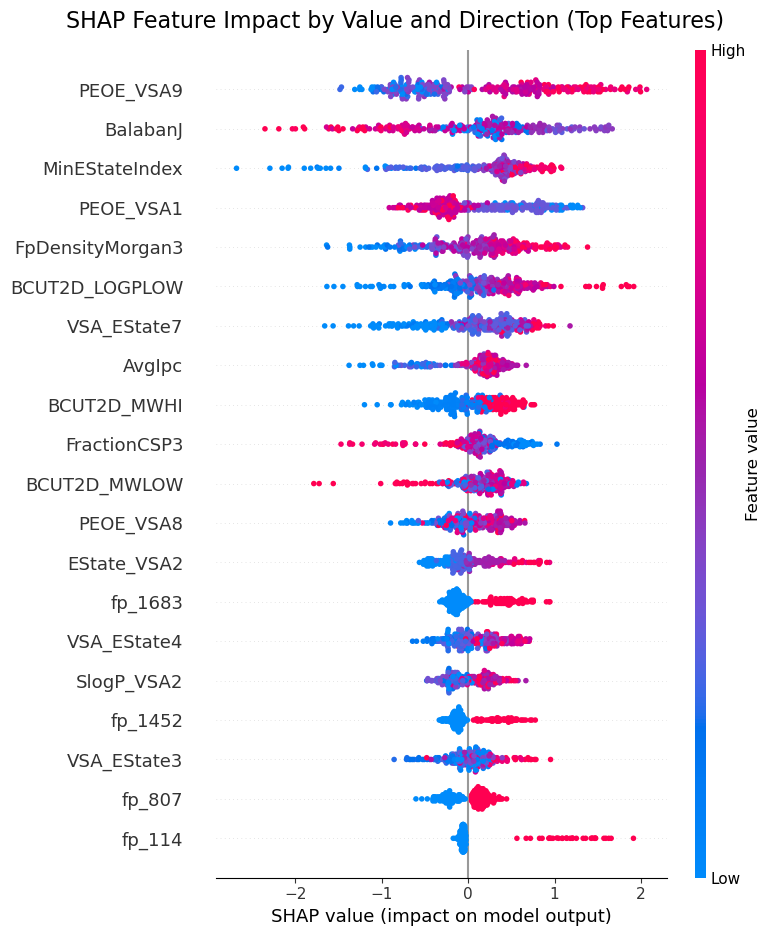

In [5]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

# read in our X data from our modeling notebook
X_model_input = pd.read_pickle("../artifacts/arrays/X_model_input_phase1.pkl")

# Rebuild test set as a df with right columns
X_test_df = pd.DataFrame(X_test, columns = X_model_input.columns)

# Initialize SHAP Explainer using previously loaded optimized model
explainer = shap.Explainer(model)

# Compute SHAP values (on test set only)
shap_exp = explainer(X_test_df)

# Global summary bar plot( with the mean SHAP values)
plt.figure(figsize = (10,6))
shap.summary_plot(shap_exp, X_test_df, plot_type = 'dot', show = False)
plt.suptitle("SHAP Feature Impact by Value and Direction (Top Features)", fontsize = 16)
plt.tight_layout()
# Save this one for our READMEs
plt.savefig("../images/shap_summary_swarm_phase1.png", dpi = 300, bbox_inches = "tight")
plt.show()

### Directional SHAP Summary Plot (Swarm)

This SHAP swarm plot visualizes both the **impact** and **directionality** of individual features across the entire test set.

- Each row corresponds to a feature, ranked by average impact on model predictions.
- Each dot represents a compound:
  - **Red = high feature value**
  - **Blue = low feature value**
- Horizontal position indicates how much that feature pushed the prediction toward the "active" or "inactive" class.

#### Key observations:
- Features like **PEOE_VSA9**, **BalabanJ**, and **FpDensityMorgan3** consistently push predictions toward activity when their values are high.
- In contrast, low values of descriptors like **MinEStateIndex** and **BCUT2D_MWHI** tend to reduce predicted activity.
- Most top features show **directional consistency**, indicating stable chemical interpretation logic across compounds.
- Fingerprint-derived features (fp_1683, fp_1452) contribute in specific cases but show more heterogenous effects, likely capturing unique structural subpatterns.

These insights form the basis for **data-driven hypotheses** and will help validate the model's predictive logic in biological terms during Phase 2.

### SHAP Waterfall Plot:  Top-Ranked Active Compound

This waterfall plot explains the model’s prediction for the top-ranked active compound. It decomposes the final predicted probability by stacking each feature's contribution on top of the model's base value (its average prediction across all compounds).

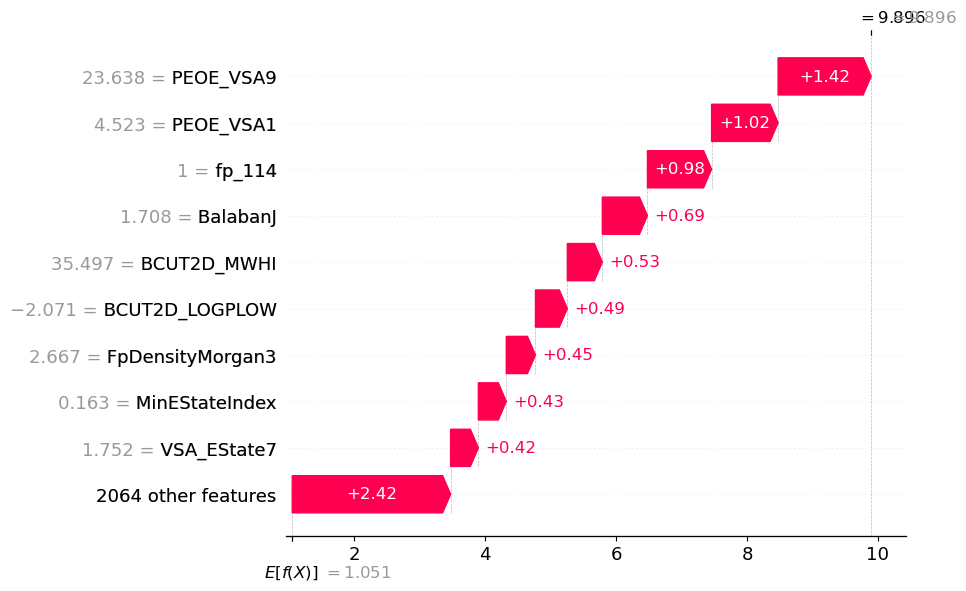

<Figure size 640x480 with 0 Axes>

In [6]:
# Find the index of the highest predicted probability
top_idx = np.argmax(y_proba)

# Confirm the compound
X_exp = X_test_df.iloc[top_idx:top_idx+1]

# run a static version of the force plot (for compatibility purposes)
shap.plots.waterfall(shap_exp[top_idx], show = True)

# Generate the force plot then with matplot
plt.tight_layout()
plt.show()


### SHAP Waterfall Plot Summary

SHAP Waterfall Plot: Top Active Compound

This waterfall plot decomposes a single compound’s prediction by showing each feature's individual SHAP contribution.

**Highlights**:

The compound had a **strong predicted probability of being active**, with a final model output near the upper range.

The primary contributors included:

**PEOE_VSA9**: largest positive contributor.

**FpDensityMorgan3** and **BCUT2D_MWHI**: secondary contributors reinforcing activity.

**fp_114** and **BalabanJ**: further nudging the model toward an active classification.

Interestingly, some features that were less important globally (fp_114, fp_323) have substantial local impact, underscoring the need to pair global + local interpretability.

This plot confirms that the model uses a **cohesive combination of charge distribution, molecular topology, and fingerprint signals** to identify actives.

### SHAP Waterfall Plot: Low-Confidence or Misclassified Prediction

To complement the confident prediction shown earlier, this plot explores a compound where the model's prediction was either **low-confidence** or **incorrect**.

By examining how individual features contributed in this case, we can gain insight into:

- Whether the model relied on misleading or weak signals
- Which features may be over- or under-weights in edge cases
- How prediction logic differs from strong classifications

This analysis helps identify potential failure modes and supports more robust feature validation in downstream phases.


#### We will build two separate waterfall plots here, one for borderline/low-confidence predictions and the other for misclassified.

Closest to 0.5 prediction: 0.5160


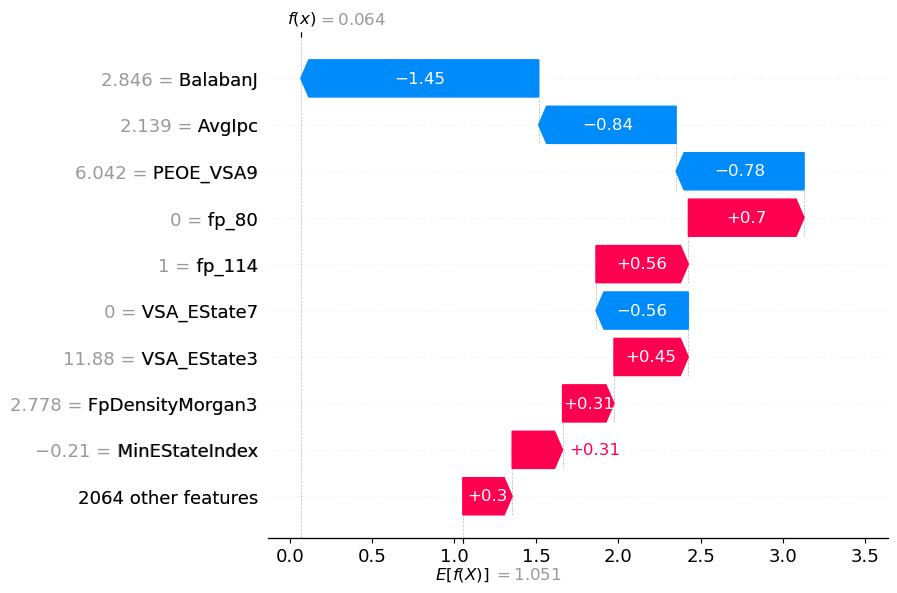

In [7]:
# Plotting the SHAP Waterfall plot for the Borderline predictions first

y_pred_bord = np.array(y_proba).flatten()

# Get the predictions closest to the default of 0.5
bord_idx = np.argmin(np.abs(y_pred_bord - 0.5))
print(f"Closest to 0.5 prediction: {y_pred_bord[bord_idx]:.4f}")

shap.plots.waterfall(shap_exp[bord_idx])

#### SHAP Waterfall Plot: Borderline Prediction (~0.5 Confidence)

This SHAP waterfall plot visualizes a **borderline compound prediction**, where the model was uncertain whether to classify it as active or inactive.

**Key Observations**:
**Net effect**: The final prediction was only marginally above the classification threshold, suggesting a **delicate balance of opposing signals**.

-**Strong negative drivers**:

-**BalabanJ** contributed **-1.45**, the most influential feature pulling the prediction toward **inactive**.

-**AvgIpc** and **PEOE_VSA9** also had sizable negative contributions, supporting the inactive direction.

**Moderate positive drivers**:

-**fp_80, fp_114, and FpDensityMorgan3 pulled the score upward**, nudging the compound closer to the active class.

-**VSA_EState3 and MinEStateIndex** also provided small positive shifts.

**Interpretation**:
This plot **exemplifies a feature conflict** scenario:

-**Topological and electrotopological indices (BalabanJ, AvgIpc)** argue against activity.

-**Fingerprint presence and local electronic features (e.g., fp_114, FpDensityMorgan3)** suggest structural similarity to known actives.

-The model was **not confident enough** to make a clear decision, highlighting an area where **experimental feedback** or **assay validation** could help refine the model.

-**These borderline cases are **biologically valuable**:

They represent **chemotypes near the decision boundary**, offering targets for exploration or active learning.

They can also flag scaffold types where model certainty is low; useful for guiding assay resource allocation.

#### Now we will look at the Misclassified cases with a final SHAP plot to round out the notebook.

Total False Positives: 18
Misclassified prediction score: 0.8808
True label: 0 | Predicted: 1


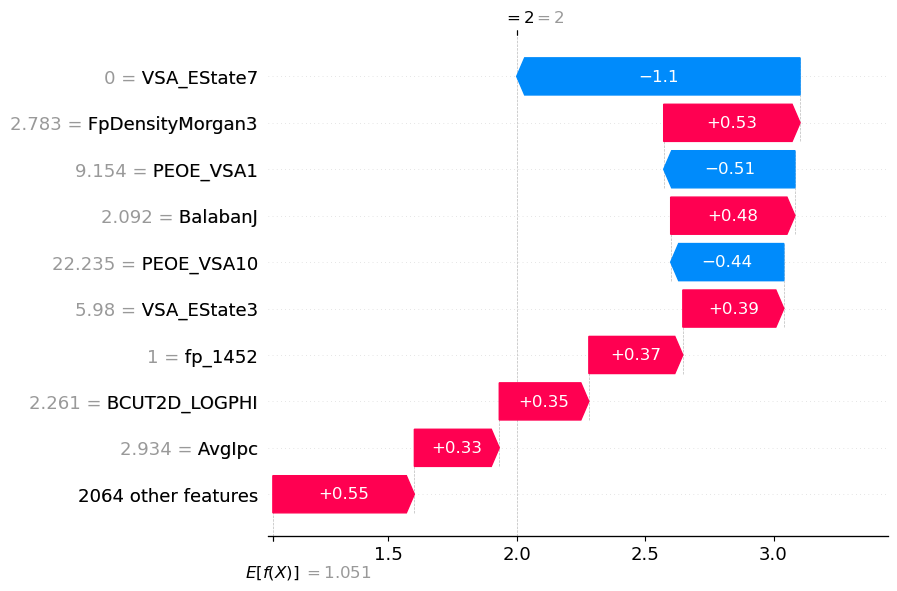

In [8]:
# Convert predictions to array and apply threshold
y_pred_mis = (np.array(y_proba) >= threshold).astype(int)

# Identify misclassified indices (False Positives)
misclassified_fp_idx = np.where((y_test == 0) & (y_pred_mis == 1))[0]

# Sanity check: how many FPs?
print(f"Total False Positives: {len(misclassified_fp_idx)}")

# Select one representative misclassified compound (first FP)
mis_idx = misclassified_fp_idx[0]
print(f"Misclassified prediction score: {y_proba[mis_idx]:.4f}")
print(f"True label: {y_test[mis_idx]} | Predicted: {y_pred_mis[mis_idx]}")

# Plot SHAP waterfall for misclassified compound
shap.plots.waterfall(shap_exp[mis_idx])

#### SHAP Waterfall Plot: Misclassified Prediction (False Positive)

This SHAP waterfall plot illustrates a **false positive**—a compound predicted as active (score = 0.8808) despite its true label being inactive.

**Key Observations**:
-Primary Contributors to Misclassification:

-**FpDensityMorgan3, BCUT2D_LOGPHI, and AvgIpc** added positive SHAP values, pushing the prediction toward the active class.

-These features were consistent with those found in true actives, which likely misled the model.

**Counteracting Signals**:

-**VSA_EState7, PEOE_VSA1, and PEOE_VSA10** contributed negative SHAP values, pulling the score toward inactivity.

-However, their combined effect was insufficient to offset the strong active-driving features.

**Implication**:

This compound exhibits a mix of active-like and inactive-like traits, making it **chemically ambiguous** under the current feature space.

It highlights a plausible **edge case** the model struggles with—where known inactive compounds mimic physicochemical signals typical of actives.

**Strategic Value**:
Analyzing misclassifications like this:

-Helps uncover **model blind spots**.

-Guides future **feature refinement** (e.g., weighting VSA_EState features more heavily).

-May uncover **novel chemical motifs** that require biological clarification—some false positives may actually be borderline or misannotated in ChEMBL.

This local interpretability snapshot complements the earlier global SHAP analyses and will inform hypothesis generation in the next notebook.

### Phase 1 Summary: Bioactivity Prediction and Early Prioritization

We have successfully completed Phase 1 of the BioPred_DS project, which focused on modeling GABA-A receptor bioactivity using high-confidence compound–assay data. This phase served to evaluate the model’s ability to enrich for active compounds early in the ranked list and to interpret the underlying chemical features driving predictions.

#### Model Performance
**Final model**: XGBoost classifier selected after baseline comparison and optimization.

Test ROC AUC: ~0.937 — strong class separation.

Test PR AUC: ~0.973 — robust early precision under class imbalance.

Thresholding: A precision-optimized threshold (0.6492) was applied to align scoring with screening goals.

#### Prioritization Metrics
**Enrichment Factor (EF):**

EF@1% = 0.98 (near-random due to low actives)

EF@5% = 1.37

EF@10% = 1.37

**Precision@k:**

Precision@10 = 1.00

Precision@50 = 1.00

Precision@100 = 1.00
These results confirm the model’s utility in early-stage compound triage, returning high-confidence actives within realistic screening budgets.

#### Interpretability Insights
Global SHAP analysis revealed dominant features such as PEOE_VSA9, BalabanJ, and FpDensityMorgan3 as strong, directionally consistent drivers of activity.

**Local SHAP plots:**

A confident active prediction was dissected to show additive SHAP contributions from key fingerprint and physical descriptors.

A borderline prediction (near 0.5) highlighted feature conflicts and helped identify edge-case uncertainty.

Together, these plots demonstrated the model’s biologically coherent reasoning, suitable for downstream hypothesis generation.

## Next Steps: Hypothesis Generation and Rediscovery Analysis

With model training, thresholding, and evaluation complete, we now transition into two final analyses to close out Phase 1:

---

### 1. **Data-Driven Hypothesis Generation**

Using the SHAP summary and waterfall plots from the current notebook, we will:

- Select 3-5 key features with **strong directional impact** on predicted bioactivity.
- Formulate **quantitative, testable hypotheses** about their influence.
- Conduct appropriate **statistical testing** (e.g., Welch's t-test, Mann-Whitney U test, etc) to validate whether the observed model-driven patterns hold in the raw data distribution.
- Frame the results in terms of their **biological interpretability** and implications for compound prioritization or further wet-lab validation.

This allows us to close the loop between model output and scientific reasoning—a crucial step for Discovery DS pipelines.

---

### 2. **Rediscovery of Known Compounds**

We will also revisit the top-ranked hits from the precision-optimized shortlist and:

- **Re-query ChEMBL** to map predicted hits back to known drugs or ligands targeting GABA-A receptors.
- Annotate which of our top predictions are **validated rediscoveries** versus potentially novel actives.
- Summarize rediscovery rates and include supporting metadata (e.g., compound names, SMILES, known indications) in a concise results table.

This step provides a key **scientific validation layer**, demonstrating that the model is not only performant in metrics, but also capable of resurfacing meaningful biology—an essential benchmark for downstream deployment or translation into the drug discovery pipeline.

---

Together, these final notebooks ensure Phase 1 closes with interpretability, hypothesis alignment, and biological grounding—all of which position the model for practical use and transition into Phase 2.
